In [1]:
import pandas as pd
import seaborn as sns
import glob
from numpy import genfromtxt
# from sklearn.metrics import f1_score
from matplotlib import pyplot as plt
import numpy as np
import json
from collections import OrderedDict
import os
import re
import logging
import multiprocessing
from functools import partial
from datetime import datetime
from Bio import SeqIO
from Bio.Seq import Seq
import gzip
from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold
# https://pandas.pydata.org/docs/getting_started/intro_tutorials/03_subset_data.html
import seaborn as sns

In [2]:
def binary_label(y_class):
    y_bin = []
    nonenan_index = []
    for i in range(len(y_class)):
        if y_class[i]=='R' or y_class[i]=='I':
            y_bin.append(1)
            nonenan_index.append(i)
        elif y_class[i]=='S':
            y_bin.append(0)
            nonenan_index.append(i)
        else:
            y_bin.append(y_class[i])
    return np.array(y_bin), nonenan_index

In [3]:
metadata_panta = pd.read_csv("../data/Ecoli1936metafiles/metadata_final.csv")

In [4]:
metadata_panta.shape, metadata_panta.head(2)

((1653, 14),
      Isolate    Year CTZ CTX AMP  AMX AMC TZP CXM CET GEN TBM TMP CIP
 0  11658_4#1  2006.0   S   S   S  NaN   S   S   R   S   S   S   S   S
 1  11657_5#1  2006.0   S   S   R  NaN   R   S   S   S   S   S   R   R)

In [5]:
accession_isolate = pd.read_csv("../data/Ecoli1936metafiles/sample_isolate.csv")

In [6]:
iso2accessiondict = {}
for i in range(len(accession_isolate.index)):
    iso2accessiondict[accession_isolate.iloc[i,1]] = accession_isolate.iloc[i,0]

In [7]:
# iso2accessiondict # {'11658_4#2': 'SAMEA2204231', '11657_5#3': 'SAMEA2204244',...

In [8]:
idx = 3 # start from 2
y_class = metadata_panta.iloc[:,idx].values
y, nonenan_index = binary_label(y_class)
y_new = y[nonenan_index].astype(int)

In [9]:
len(y_class), len(y_new)

(1653, 1576)

In [10]:
mlstinfo = pd.read_csv("Ecolimlst.csv", header=None)

In [11]:
mlstinfo.shape, mlstinfo.head(2)

((1653, 10),
                                                    0      1    2        3  \
 0  /data/hoan/amromics/prediction/data/Ecoli1936/...  ecoli  135  adk(13)   
 1  /data/hoan/amromics/prediction/data/Ecoli1936/...  ecoli   10  adk(10)   
 
           4         5        6        7         8         9  
 0  fumC(39)  gyrB(50)  icd(13)  mdh(16)  purA(37)  recA(25)  
 1  fumC(11)   gyrB(4)   icd(8)   mdh(8)   purA(8)   recA(2)  )

In [12]:
accession2ST = {}
for i in range(len(mlstinfo.index)):
    acs = mlstinfo.iloc[i,0].split('/')[-1].split('.')[0]
    sttype = mlstinfo.iloc[i,2]
    accession2ST[acs] = sttype

In [13]:
# accession2ST

In [14]:
STInfo = []
for iso in metadata_panta['Isolate'].values:
    accession = iso2accessiondict[iso]
    if accession in accession2ST:
        STInfo.append(str(accession2ST[accession]))
    else:
        STInfo.append(np.nan)

In [15]:
metadata_panta['ST'] = STInfo

In [16]:
metadata_panta.head(2)

,Isolate,Year,CTZ,CTX,AMP,AMX,AMC,TZP,CXM,CET,GEN,TBM,TMP,CIP,ST
0,11658_4#1,2006.0,S,S,S,NaN,S,S,R,S,S,S,S,S,135
1,11657_5#1,2006.0,S,S,R,NaN,R,S,S,S,S,S,R,R,10


In [17]:
metadata_panta.to_csv("metadataEcoliST.csv", index=None)

In [18]:
# plt.figure(figsize=(15, 5))
# my_plot = sns.countplot(data=metadata_panta, x='ST')
# my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=90)
# plt.show()

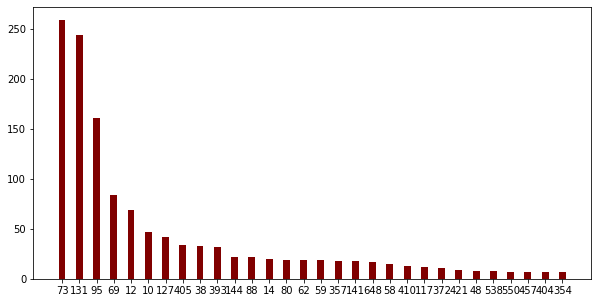

In [19]:
newdf = pd.DataFrame(metadata_panta['ST'].value_counts()[:30])
newdf['type'] = newdf.index.values
plt.figure(figsize=(10, 5))
plt.bar(newdf['type'], newdf.iloc[:,0].values, color ='maroon', 
        width = 0.4)
plt.show()

In [20]:
# remove rare subtypes (less than 1%)
newdf = pd.DataFrame(metadata_panta['ST'].value_counts()[:20])
newdf['type'] = newdf.index.values # ST is total count
newdf.head(2)

,ST,type
73,259,73
131,244,131


In [21]:
column_names = list(metadata_panta.columns.values)
# column_names

In [23]:
# dfsubS.head(2)

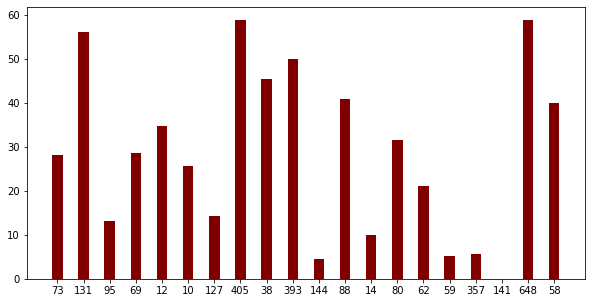

In [24]:
amrindex = 4
dfsub = metadata_panta.iloc[:,[amrindex+2,-1]]
dfsub = dfsub.dropna()
dfsubS = dfsub[dfsub.iloc[:,0]=='R']
ratiovec = []
for i in range(len(newdf.index)):
    subtype = newdf.iloc[i, 1]
    total = newdf.iloc[i, 0]
    ratio = len(dfsubS[dfsubS['ST'] == subtype])*100.0/total
    ratiovec.append(ratio)
plt.figure(figsize=(10, 5))
plt.bar(newdf['type'], ratiovec, color ='maroon', width = 0.4)
plt.show()

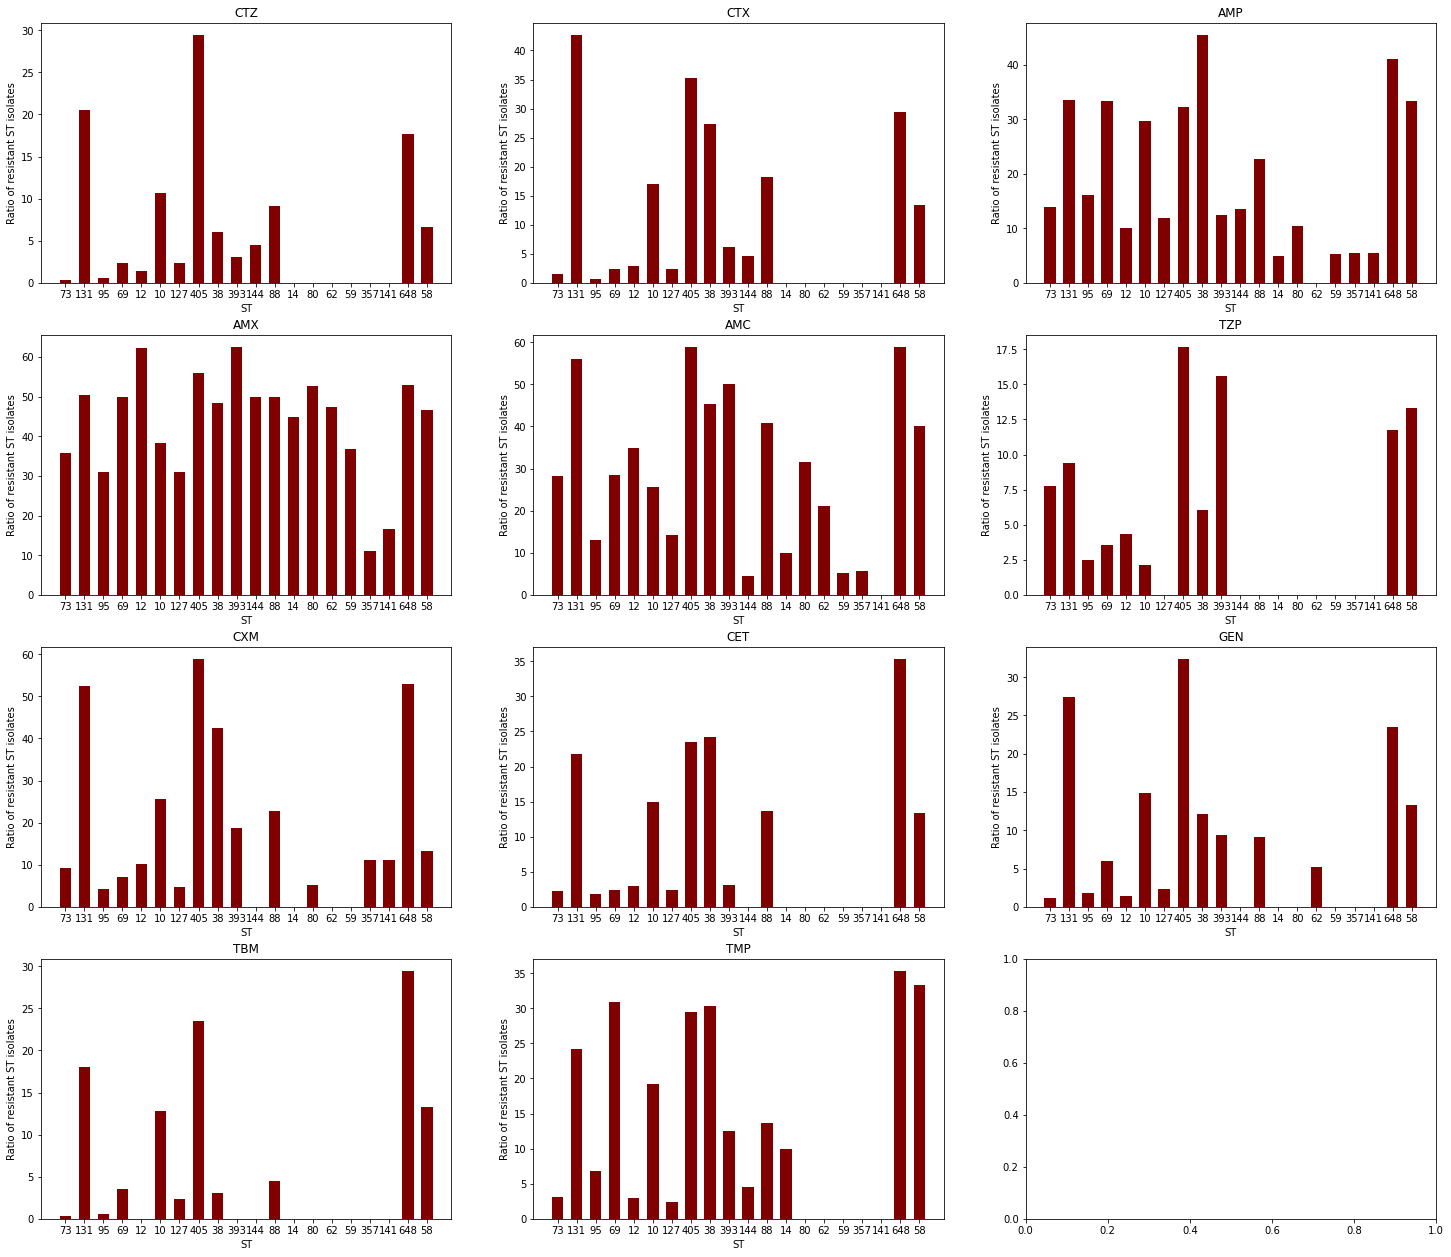

In [35]:
nPlots = 11
fig, ax =plt.subplots(4, 3, figsize=(25, 22))
for amrindex in range(nPlots):
    # amrindex = 4
    dfsub = metadata_panta.iloc[:,[amrindex+2,-1]]
    dfsub = dfsub.dropna()
    dfsubS = dfsub[dfsub.iloc[:,0]=='R']
    ratiovec = []
    for i in range(len(newdf.index)):
        subtype = newdf.iloc[i, 1]
        total = newdf.iloc[i, 0]
        ratio = len(dfsubS[dfsubS['ST'] == subtype])*100.0/total
        ratiovec.append(ratio)
    # print(ratiovec)
    # plt.figure(figsize=(10, 5))
    ax = plt.subplot(4, 3, amrindex+1)
    ax.bar(newdf['type'], ratiovec, color ='maroon', width = 0.6)
    ax.set_title(column_names[amrindex+2])
    ax.set_ylabel("Ratio of resistant ST isolates")
    ax.set_xlabel("ST")
plt.show()